# Exercise 8

## Group ID: 
*   Person1
*   Person2
*   Person3

## Exercise day: Tuesday/Wednesday






### Imports

In [ ]:
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance, ImageFont, ImageOps

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from tqdm import tqdm

device = 'cpu'

Data Loading and Splitting - For faster training we only take subsample of FashionMNIST

Training subset shape: torch.Size([7000, 1, 28, 28]), torch.Size([7000])
Test subset shape: torch.Size([7000, 1, 28, 28]), torch.Size([7000])

Training Subset Class Distribution:
T-shirt/top: 689
Trouser: 692
Pullover: 737
Dress: 670
Coat: 721
Sandal: 742
Shirt: 708
Sneaker: 680
Bag: 664
Ankle boot: 697

Test Subset Class Distribution:
T-shirt/top: 704
Trouser: 705
Pullover: 701
Dress: 701
Coat: 709
Sandal: 709
Shirt: 701
Sneaker: 694
Bag: 691
Ankle boot: 685


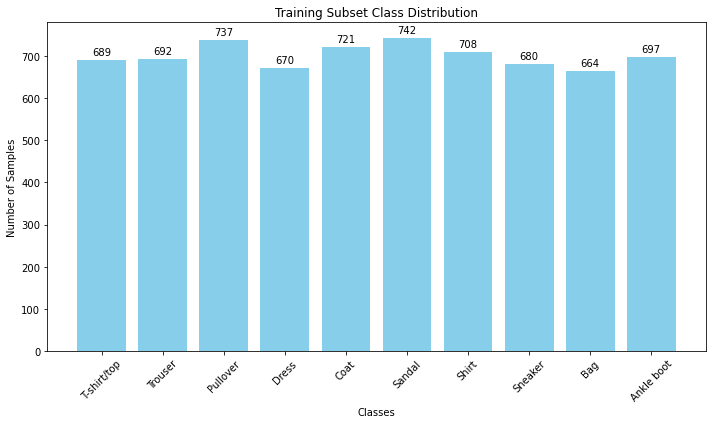

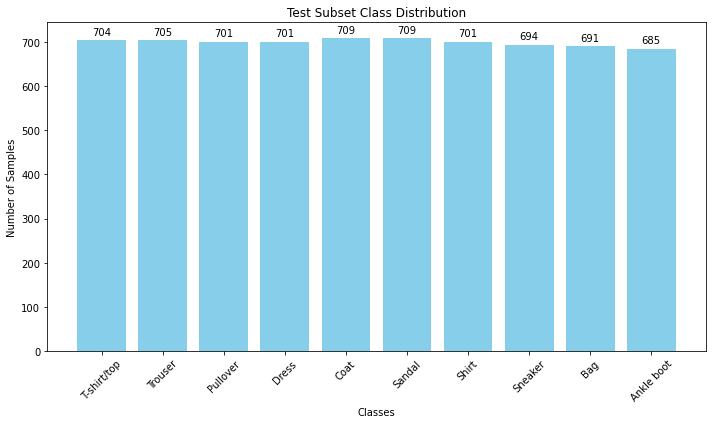

In [ ]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# Define class names for FashionMNIST
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Load FashionMNIST dataset
fashion_mnist_train = datasets.FashionMNIST(root='data', train=True, download=True)
fashion_mnist_test = datasets.FashionMNIST(root='data', train=False, download=True)

# Normalize and reshape data
X_train = fashion_mnist_train.data.reshape(-1, 1, 28, 28).float() / 255
y_train = fashion_mnist_train.targets

X_test = fashion_mnist_test.data.reshape(-1, 1, 28, 28).float() / 255
y_test = fashion_mnist_test.targets

# Function to shuffle and select a subset
def shuffle_and_subset(X, y, subset_size, seed=42):
    if seed is not None:
        torch.manual_seed(seed)
    permuted_indices = torch.randperm(X.size(0))
    selected_indices = permuted_indices[:subset_size]
    return X[selected_indices], y[selected_indices]

def calculate_class_distribution(y, class_names):
    classes, counts = torch.unique(y, return_counts=True)
    distribution = {class_names[int(cls)]: int(count) for cls, count in zip(classes, counts)}
    return distribution

def plot_class_distribution(distribution, title):
    classes = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=45)

    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

subset_size = 7000
random_seed = 42

X_train_subset, y_train_subset = shuffle_and_subset(X_train, y_train, subset_size, seed=random_seed)

X_test_subset, y_test_subset = shuffle_and_subset(X_test, y_test, subset_size, seed=random_seed + 1)  # Different seed for test

print(f"Training subset shape: {X_train_subset.shape}, {y_train_subset.shape}")
print(f"Test subset shape: {X_test_subset.shape}, {y_test_subset.shape}")

train_distribution = calculate_class_distribution(y_train_subset, class_names)
test_distribution = calculate_class_distribution(y_test_subset, class_names)

print("\nTraining Subset Class Distribution:")
for cls, count in train_distribution.items():
    print(f"{cls}: {count}")

print("\nTest Subset Class Distribution:")
for cls, count in test_distribution.items():
    print(f"{cls}: {count}")

plot_class_distribution(train_distribution, "Training Subset Class Distribution")
plot_class_distribution(test_distribution, "Test Subset Class Distribution")

X_train, y_train, X_test, y_test = X_train_subset, y_train_subset, X_test_subset, y_test_subset

### PyTorch Dataset and DataLoader

To make the training process easier, we will use the PyTorch `Dataset` and `DataLoader` classes. The Dataset class is an abstract class representing a dataset, while the DataLoader class provides an iterable over a dataset. In this case, we use the `TensorDataset` to wrap our data and the DataLoader class to iterate over the training and validation datasets.

In [41]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Description

In this exercise, we will explore two key aspects of enhancing deep learning models:

1. Adding stochastic depth to ResNet: Learn how to incorporate this regularization technique to improve model robustness.

2. The role of data augmentation: Understand its impact on improving generalization and training performance.


The task is divided into the following sections, with points allocated as follows:

1. Implementing stochastic depth (1 point): Add stochastic depth to the ResNet architecture.

2. Implementing data augmentation (2 points): Design and apply data augmentation techniques to the training pipeline.

3. Training and evaluation (2 points): Train ResNet with and without data augmentation, and compare the results to highlight the benefits of augmentation

### Implementing stochastic depth (1p)

Stochastic depth is a regularization technique used in ResNet to improve training efficiency and generalization by randomly "dropping" entire residual blocks during training. Specifically, for each forward pass, certain residual blocks are skipped (i.e., their outputs are set to zero) with a probability defined for each block. This introduces randomness, effectively training the network as an ensemble of subnetworks of varying depths.

In [42]:
# The following code is copied from the lecture. Please add stochastic depth implementation.

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, c_in=1, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64, stride=1),
            ResidualBlock(64, 64, stride=1)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256, stride=1)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512, stride=1)
        )

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Implementing stochastic depth - Tests

Those tests assume that in ResNet that the keep probability assigned to the last residual block in the network is defined as p_L.

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import gradcheck

def test_forward_training_mode():
    print("Running test_forward_training_mode...")
    torch.manual_seed(0)
    batch_size = 4
    num_classes = 10
    input_channels = 1
    image_size = 32
    model = ResNet(c_in=input_channels, num_classes=num_classes, p_L=0.5)
    model.train()
    input_tensor = torch.randn(batch_size, input_channels, image_size, image_size, requires_grad=True)
    output = model(input_tensor)
    assert output.shape == (batch_size, num_classes), f"Expected output shape {(batch_size, num_classes)}, got {output.shape}"
    assert output.requires_grad, "Output does not require gradients."
    print("test_forward_training_mode passed.")

def test_output_shape():
    print("Running test_output_shape...")
    torch.manual_seed(0)
    batch_size = 4
    num_classes = 10
    input_channels = 1
    image_size = 32
    model = ResNet(c_in=input_channels, num_classes=num_classes, p_L=0.5)
    model.train()
    input_tensor = torch.randn(batch_size, input_channels, image_size, image_size)
    output = model(input_tensor)
    assert output.shape == (batch_size, num_classes), f"Expected output shape {(batch_size, num_classes)}, got {output.shape}"
    print("test_output_shape passed.")

def test_gradient_flow():
    print("Running test_gradient_flow...")
    torch.manual_seed(0)
    batch_size = 4
    num_classes = 10
    input_channels = 1
    image_size = 32
    model = ResNet(c_in=input_channels, num_classes=num_classes, p_L=0.5)
    model.train()

    for layer in [model.layer1, model.layer2, model.layer3, model.layer4]:
        for block in layer:
            block.keep_prob = 1.0

    input_tensor = torch.randn(batch_size, input_channels, image_size, image_size, requires_grad=True)
    output = model(input_tensor)
    loss = output.sum()
    loss.backward()

    for name, param in model.named_parameters():
        if param.requires_grad:
            assert param.grad is not None, f"Parameter {name} has no gradient."
    assert input_tensor.grad is not None, "Input tensor has no gradient."
    print("test_gradient_flow passed.")


def test_gradcheck():
    print("Running test_gradcheck...")
    torch.manual_seed(0)
    model = ResNet(c_in=1, num_classes=2, p_L=0.5).double()
    model.train()
    input_tensor = torch.randn(1, 1, 8, 8, dtype=torch.double, requires_grad=True)

    for layer in [model.layer1, model.layer2, model.layer3, model.layer4]:
        for block in layer:
            block.keep_prob = 1.0

    def func(x):
        return model(x)

    test = gradcheck(func, (input_tensor,), eps=1e-6, atol=1e-4)
    assert test, "Gradcheck failed."
    print("test_gradcheck passed.")

def run_all_tests():
    test_forward_training_mode()
    test_output_shape()
    test_gradient_flow()
    print("All tests passed successfully.")

if __name__ == "__main__":
    run_all_tests()


Running test_forward_training_mode...
test_forward_training_mode passed.
Running test_output_shape...
test_output_shape passed.
Running test_gradient_flow...
test_gradient_flow passed.
All tests passed successfully.


### Implementing Data Augmentation (2p)


Data augmentation is a technique used to increase the diversity of a training dataset by applying various transformations to the input data. These transformations, such as rotations, flips, cropping, scaling, color adjustments, and noise addition, are applied in real-time during training to create new, slightly modified versions of the original data.

In this section we will implement four different Data Augmentation techniques:

1. Mixup

2. Cutmix

3. Randaugment

4. Random Erasing

Auxilary functions

In [44]:
def plot_augmentations(images, labels, num_cols=5, figsize=(15, 3)):
    num_images = len(images)
    num_rows = int(np.ceil(num_images / num_cols))

    plt.figure(figsize=figsize)

    for idx, (img, lbl) in enumerate(zip(images, labels)):
        plt.subplot(num_rows, num_cols, idx + 1)
        img = torch.clamp(img, 0, 1)
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.title(lbl, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1. Mixup

Mixup generates a new training example $x$ by taking a convex combination of two input images $x_1, x_2$:

$$ x = \lambda x_1 + (1-\lambda) x_2 $$

Correspondingly the labels $y_1, y_2$ are also mixed. So the label corresponding to observation $x$ is:

$$ y = \lambda y_1 + (1-\lambda) y_2 $$

The mixing coefficient $\lambda$ is sampled from Beta distribution $\text{Beta}(\alpha, \alpha)$

In [45]:
def mixup(image1, image2, alpha=1.0):
    pass # Add your implementation here

2. Cutmix

Given two examples $(x_i, y_i)$ and $(x_j, y_j)$ and fixed $r_{\text{min}}, r_{\text{max}}$,  we generate new sample as follows:

1. Sample mixing coefficient $\lambda \sim \text{Beta}(\alpha, \alpha)$
2. Determine the size of the patch: $$\text{Area of Patch} = (1-\lambda) HW$$
3. Sample $r \sim U[r_{\text{min}}, r_{\text{max}}]$
4. Using the area and aspect ratio, we compute the width and height:

$$h = \sqrt{\text{Area of Patch} \times r}$$
$$w = \sqrt{\frac{\text{Area of Patch}}{r}}$$

5. Randomly select coordinates $c_x$ and $c_y$ of the patch $c_x \sim U[0, W]$ and $c_y \sim U[0, H]$
6. Define the variables for the replacement:
$$x_1 = c_x - \frac w 2$$
$$y_1 = c_y - \frac h 2$$
$$x_2 = c_x + \frac w 2$$
$$y_2 = c_y + \frac h 2$$

7. Create augmented image $x$ which at the beggining is the original image $x_i$ and then we replace the part defined by $x_1, x_2, y_1, y_2$ by image $x_j$

8. Adjust $\lambda$: $$\lambda' = 1 - \frac{(x_2-x_1)(y_2-y_1)}{HW}$$

9. Mix labels: $$y = \lambda' y_i + (1 - \lambda') y_j$$

In [46]:
def cutmix(image1, image2, alpha=1.0):
    pass # add your implementation here

3. RandAugment

RandAugment applies a predefined number of random augmentation operations, each with fixed magnitudes, to an input image 
$x$. The resulting transformed image $x$, denoted as is given by:

$$x = o_N(o_{N-1}(...(o_1(x)))...)$$

We consider the following transformations:

1. rotate: Rotates the image by a randomly chosen angle determined by the specified magnitude.

2. translate_x: Shifts the image horizontally by a random amount based on the magnitude, effectively moving the content left or right.

3. translate_y :Shifts the image vertically by a random amount determined by the magnitude, moving the content up or down.

4. shear: Applies a random shear transformation to the image, slanting it horizontally or vertically based on the magnitude.

5. brightness: Adjusts the image's brightness by a random factor, either increasing or decreasing its intensity according to the magnitude.


6. contrast: Modifies the image's contrast by a random factor, enhancing or reducing the difference between light and dark areas based on the magnitude.


7. sharpness: Alters the image's sharpness by a random factor, making edges more defined or more blurred depending on the magnitude.


8. invert: Inverts the image colors, transforming each pixel to its complementary color to produce a negative of the original image.

In [4]:
def apply_randaugment_operation(image, operation, magnitude):
    if operation == 'rotate':
        pass

    elif operation == 'translate_x':
        pass

    elif operation == 'translate_y':
        pass

    elif operation == 'shear':
        pass

    elif operation == 'brightness':
        pass

    elif operation == 'contrast':
        pass

    elif operation == 'sharpness':
        pass

    elif operation == 'invert':
        pass

    else:
        return image

def rand_augment(image, num_ops=2, magnitude=9):
    operations = [
        'rotate',
        'translate_x',
        'translate_y',
        'shear',
        'brightness',
        'contrast',
        'sharpness',
        'invert'
    ]

    pil_image = transforms.ToPILImage()(image)

    for _ in range(num_ops):
        op = random.choice(operations)
        pil_image = apply_randaugment_operation(pil_image, op, magnitude)

    augmented_image = transforms.ToTensor()(pil_image)
    return augmented_image

4. Randon Erasing

Random Erasing is a data augmentation technique that randomly selects a rectangular region within an image and replaces its pixels with either a constant value or random noise.

In [48]:
def random_erasing(image, ...):
    pass

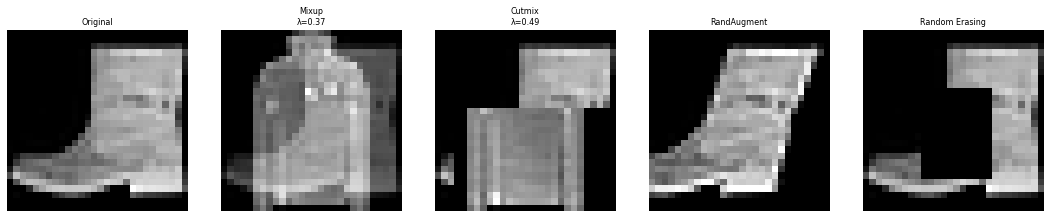

In [49]:
image1 = X_train[0]
image2 = X_train[1]

# 1. Mixup
mixed_image_mixup, lam_mixup = mixup(image1, image2, alpha=1.0)

# 2. Cutmix
mixed_image_cutmix, lam_cutmix = cutmix(image1, image2, alpha=1.0)

# 3. RandAugment
augmented_image_randaug = rand_augment(image1, num_ops=2, magnitude=9)

# 4. Random Erasing
augmented_image_erased = random_erasing(image1.clone(), p=1.0)

# List of original and augmented images with labels
original_image = image1
augmented_images = [
    (original_image, "Original"),
    (mixed_image_mixup, f"Mixup\nλ={lam_mixup:.2f}"),
    (mixed_image_cutmix, f"Cutmix\nλ={lam_cutmix:.2f}"),
    (augmented_image_randaug, "RandAugment"),
    (augmented_image_erased, "Random Erasing")
]

# Separate images and labels
images, labels = zip(*augmented_images)

# Plot the augmentations
plot_augmentations(images, labels, num_cols=5, figsize=(15, 3))


### Training and Evaluation (2p)

In this section, we provide a pre-implemented training loop for the model without data augmentation. Your task is to implement a training loop that incorporates data augmentation into the process.

In [1]:
def validate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(dataloader, desc="Validating"):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            X_batch = X_batch.reshape(-1, 1, 28, 28)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = correct / total
    return accuracy


def train(model, dataloader, test_loader, num_epochs=5, lr=0.01):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    losses = []
    val_accs = []
    train_accs = []

    print("### TRAINING MODEL WITHOUT DATA AUGMENTATION ###")
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_loss = 0.0
        for X_batch, y_batch in tqdm(dataloader, desc="Batches", leave=False):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            X_batch = X_batch.reshape(-1, 1, 28, 28)

            optimizer.zero_grad()

            preds = model(X_batch)

            loss = criterion(preds, y_batch)
            epoch_loss += loss.item() * X_batch.size(0)

            loss.backward()
            optimizer.step()

        epoch_loss /= len(dataloader.dataset)
        losses.append(epoch_loss)

        val_acc = validate(model, test_loader)
        val_accs.append(val_acc)

        train_acc = validate(model, dataloader)
        train_accs.append(train_acc)

        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Training Accuracy: {train_acc:.4f}")

    return losses, val_accs, train_accs


def train_with_augmentation(model, dataloader, test_loader, num_epochs=5, lr=0.0001):
    pass

print('### Train ResNet without Data Augmentation ###')
print("Initialize model")
model_no_aug = ResNet(c_in=1, num_classes=10, p_L=0.5).to(device)

print('Train the model')
losses_no_aug, val_accs_no_aug, train_accs_no_aug = train(
    model=model_no_aug,
    dataloader=train_loader,
    test_loader=test_loader,
    num_epochs=5,
    lr=0.01
)

print('### Train ResNet with Data Augmentation ###')
print("Initialize model")
model_aug = ResNet(c_in=1, num_classes=10, p_L=0.5).to(device)

print('Train the model')
losses_aug, val_accs_aug, train_accs_aug = train_with_augmentation(
    model=model_aug,
    dataloader=train_loader,
    test_loader=test_loader,
    num_epochs=5,
    lr=0.0001
)

Visualize the results

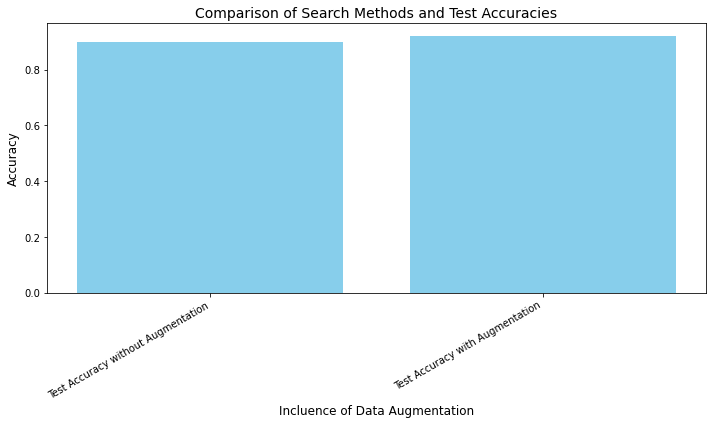

In [3]:
# Data for the bar plot
labels = ['Test Accuracy without Augmentation',
          'Test Accuracy with Augmentation',]

values = [
        val_accs_no_aug[-1],
          val_accs_aug[-1],
          ]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Incluence of Data Augmentation', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Search Methods and Test Accuracies', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.tight_layout()
plt.show()